In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
import glob
import json
import seaborn as sns
from datetime import datetime
from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
import re
from matplotlib import colormaps  
from aind_analysis_arch_result_access.han_pipeline import get_mle_model_fitting
from scipy.stats import linregress
from typing import Sequence



In [2]:
#Load kinematics data
from tongue_kinematics_utils import load_keypoints_from_csv, find_behavior_videos_folder, integrate_keypoints_with_video_time

#keypoints
LP_csv_path = '/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_716325_2024-05-31_10-31-14/bottom_camera.csv'

keypoint_dfs = load_keypoints_from_csv(LP_csv_path)

session_name = os.path.basename(os.path.dirname(LP_csv_path))
behavior_videos_folder = find_behavior_videos_folder(f'/root/capsule/data/{session_name}')

#get video timebase for keypoint dataframe
keypoint_dfs_trimmed, video_csv_trimmed = integrate_keypoints_with_video_time(
    os.path.join(behavior_videos_folder, 'bottom_camera.csv'), 
    keypoint_dfs
)

keypoints extracted: ['nose_tip', 'jaw', 'tongue_tip_right', 'tongue_tip_center', 'tongue_tip_left', 'pointer_finger_r', 'paw_wrist_r', 'pointer_finger_l', 'paw_wrist_l', 'spout_r', 'spout_l']
Video QC: Frame numbers are sequential with no gaps.
Video QC: Timing differences are within expected range.
keypoint_df trimmed from 2689719 to 2689718


In [3]:
#tongue kinematics processing and movement annotation
from tongue_kinematics_utils import mask_keypoint_data, kinematics_filter, segment_movements_trimnans
tongue_masked = mask_keypoint_data(keypoint_dfs_trimmed,'tongue_tip_center',confidence_threshold=0.90)
tongue_filtered = kinematics_filter(tongue_masked,cutoff_freq=50,filter_order=4,filter_kind='cubic')
tongue_segmented = segment_movements_trimnans(tongue_filtered, max_dropped_frames=10)


In [4]:
#connect to nwb dfs
from kinematics_nwb_utils import get_nwb_file
import aind_dynamic_foraging_data_utils.nwb_utils as nwb_utils
from aind_dynamic_foraging_basic_analysis.licks import annotation

nwb = get_nwb_file(session_name)
nwb.df_events = nwb_utils.create_events_df(nwb)
nwb.df_trials = nwb_utils.create_df_trials(nwb)
nwb.df_licks = annotation.annotate_licks(nwb)

Loading NWB from /root/capsule/data/foraging_nwb_bonsai/716325_2024-05-31_10-31-14.nwb


/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
Timestamps are adjusted such that `_in_session` timestamps start at the first go cue


In [6]:
from tongue_kinematics_utils import annotate_trials_in_kinematics, annotate_licks_in_kinematics, assign_movements_to_licks

tongue_segmented = annotate_trials_in_kinematics(tongue_segmented, nwb.df_trials)
tongue_marked = annotate_licks_in_kinematics(tongue_segmented, nwb.df_licks, tolerance=0.01)
nwb.df_licks = assign_movements_to_licks(tongue_marked, nwb.df_licks)

In [7]:
from tongue_kinematics_utils import aggregate_tongue_movements, add_lick_metadata_to_movements

tongue_movements = aggregate_tongue_movements(tongue_marked,keypoint_dfs_trimmed)

tongue_movements = add_lick_metadata_to_movements(
    tongue_movements,
    nwb.df_licks,
    fields=['cue_response', 'rewarded', 'event']
)


In [11]:
import pickle

with open('/root/capsule/scratch/behavior_716325_2024-05-31_10-31-14_curated_soma_opto_tagging_summary.pkl', 'rb') as file:
    ephys_data = pickle.load(file)





In [12]:
ephys_data.columns

Index(['bl_max_p', 'p_max', 'p_mean', 'lat_max_p', 'lat_mean', 'euc_max_p',
       'corr_max_p', 'opto_pass', 'amp', 'peak', 'real_unit', 'y_loc',
       'pass_count', 'spike_times', 'ks_unit_id', 'isi_violations_ratio',
       'firing_rate', 'presence_ratio', 'amplitude_cutoff', 'decoder_label',
       'depth', 'snr', 'waveform_mean', 'waveform_sd', 'default_qc', 'peak_wf',
       'peak_wf_aligned', 'wf_2d', 'LC_range_top', 'LC_range_bottom',
       'tagged_loc', 'tagged', 'unit_id', 'amplitude_opt', 'peak_wf_opt',
       'mat_wf_opt', 'peak_wf_opt_aligned'],
      dtype='object')

In [13]:
first_go_cue_time = nwb.df_trials['goCue_start_time_raw'].iloc[0]

ephys_data['spike_times_in_session'] = ephys_data['spike_times'].apply(lambda x: x - first_go_cue_time)


In [14]:
nwb.df_trials.columns

Index(['trial', 'animal_response', 'rewarded_historyL', 'rewarded_historyR',
       'bait_left', 'bait_right', 'base_reward_probability_sum',
       'reward_probabilityL', 'reward_probabilityR',
       'reward_random_number_left', 'reward_random_number_right',
       'left_valve_open_time', 'right_valve_open_time', 'block_beta',
       'block_min', 'block_max', 'min_reward_each_block', 'delay_beta',
       'delay_min', 'delay_max', 'delay_duration', 'ITI_beta', 'ITI_min',
       'ITI_max', 'ITI_duration', 'response_duration',
       'reward_consumption_duration', 'reward_delay', 'auto_waterL',
       'auto_waterR', 'laser_on_trial', 'laser_wavelength', 'laser_location',
       'laser_1_power', 'laser_2_power', 'laser_on_probability',
       'laser_duration', 'laser_condition', 'laser_condition_probability',
       'laser_start', 'laser_start_offset', 'laser_end', 'laser_end_offset',
       'laser_protocol', 'laser_frequency', 'laser_rampingdown',
       'laser_pulse_duration', 'session

In [15]:
nwb.df_licks.columns

Index(['timestamps', 'data', 'event', 'raw_timestamps', 'trial', 'pre_ili',
       'post_ili', 'bout_start', 'bout_end', 'bout_number', 'likely_artifact',
       'rewarded', 'bout_rewarded', 'cue_response', 'bout_cue_response',
       'intertrial_choice', 'bout_intertrial_choice', 'cue_switch',
       'iti_switch', 'bout_cue_switch', 'bout_iti_switch', 'within_session',
       'nearest_movement_id'],
      dtype='object')

In [16]:
tongue_segmented.columns

Index(['time', 'x', 'y', 'v', 'xv', 'yv', 'time_raw', 'confidence',
       'movement_id', 'time_in_session', 'trial'],
      dtype='object')

In [17]:
# =========================
# Core Utilities
# =========================

def generate_event_times(df, time_col, trial_col, filters=None, cue_times=None):
    """
    Extracts a single event time per trial based on filtering and trial structure.

    Parameters:
        df (DataFrame): Source dataframe containing time data.
        time_col (str): Name of the column with event timestamps.
        trial_col (str): Column indicating trial identity.
        filters (dict): Optional filters. 
                        Special keys include 'cue_response' and 'min_after_cue'.
        cue_times (dict): Dict of trial -> go cue time, used for filtering.

    Returns:
        dict: trial_id -> event_time
    """
    times = {}
    for tr in df[trial_col].unique():
        sub = df[df[trial_col] == tr].copy()
        if filters:
            for fcol, fval in filters.items():
                if fcol == 'cue_response':
                    sub = sub[sub[fcol] == fval]
                elif fcol == 'min_after_cue':
                    t0 = cue_times.get(tr, np.inf)
                    sub = sub[sub[time_col] > t0]
        if sub.empty:
            continue
        if 'movement_id' in sub.columns:
            mid = sub['movement_id'].min()
            t_event = sub[sub['movement_id'] == mid][time_col].min()
        else:
            t_event = sub[time_col].min()
        times[tr] = t_event
    return times


def build_event_df(events_dict):
    """
    Constructs a DataFrame of event times for each trial.

    Parameters:
        events_dict (dict): event_name -> (df, time_col, trial_col[, filters])

    Returns:
        DataFrame: index = trials, columns = event times
    """
    if 'goCue' not in events_dict:
        raise ValueError("events_dict must contain a 'goCue' entry")
    
    cue_times = generate_event_times(*events_dict['goCue'])
    trials = sorted(cue_times.keys())
    E = pd.DataFrame(index=trials)

    for name, params in events_dict.items():
        df, time_col, trial_col, *rest = params
        filt = rest[0] if rest else {}
        times = generate_event_times(df, time_col, trial_col, filt, cue_times)
        E[name] = pd.Series(times)

    return E.astype(float)


def sort_trials_by_latency(trials, event_times, event1, event2):
    """
    Sorts trials by the latency between two events.

    Parameters:
        trials (list): Trial IDs.
        event_times (dict): event_name -> {trial_id -> time}.
        event1, event2 (str): Event names to compute latency.

    Returns:
        list: Sorted trial IDs.
    """
    return sorted(
        [
            tr for tr in trials
            if np.isfinite(event_times[event1].get(tr, np.nan))
            and np.isfinite(event_times[event2].get(tr, np.nan))
        ],
        key=lambda tr: event_times[event1][tr] - event_times[event2][tr]
    )


# =========================
# Spike Raster Matrix
# =========================

def compute_raster_matrix(spikes, trial_ids, event_times, pre=1.0, post=2.0, bin_size=0.001):
    """
    Converts spike times to a trial-by-time bin raster matrix.

    Parameters:
        spikes (1D array): All spike times.
        trial_ids (list): List of trial IDs.
        event_times (dict): trial_id -> alignment time.
        pre, post (float): Time before/after event to include (seconds).
        bin_size (float): Time bin width in seconds.

    Returns:
        tuple: (raster matrix, bin centers, trial_ids)
    """
    n_trials = len(trial_ids)
    n_bins = int(np.round((pre + post) / bin_size))
    raster = np.zeros((n_trials, n_bins), dtype=np.uint8)
    bins = np.linspace(-pre, post, n_bins, endpoint=False) + bin_size / 2

    for i, tr in enumerate(trial_ids):
        t0 = event_times.get(tr, np.nan)
        if np.isnan(t0):
            continue
        rel = spikes - t0
        sel = (rel >= -pre) & (rel < post)
        rel = rel[sel]
        idx = ((rel + pre) / bin_size).astype(int)
        for j in idx:
            if 0 <= j < n_bins:
                raster[i, j] += 1
    return raster, bins, trial_ids


# =========================
# Plotting Utilities
# =========================

def plot_spikes(raster, bins, ax=None, color='black'):
    """
    Plot spike raster given binary/count matrix.

    Parameters:
        raster (2D array): Trials x time bins.
        bins (1D array): Time bin centers.
        ax (Axes): Optional matplotlib axis.
        color (str): Line color.

    Returns:
        Axes: Modified axis.
    """
    if ax is None:
        fig, ax = plt.subplots()
    for i, row in enumerate(raster):
        spk_idx = np.nonzero(row)[0]
        ax.vlines(bins[spk_idx], i + 0.5, i + 1.5, color=color)
    return ax


def plot_event_lines(ax, ordered_trials, events):
    """
    Overlay event-aligned lines on spike raster plot.

    Parameters:
        ax (Axes): Matplotlib axis.
        ordered_trials (list): List of trial indices in display order.
        events (dict): event_name -> {'times': {trial_idx: t_rel}, 'style': dict}

    Returns:
        Axes: Modified axis.
    """
    n = len(ordered_trials)
    for name, info in events.items():
        times_dict = info['times']
        style = info.get('style', {})
        for i in range(n):
            t_rel = times_dict.get(i)
            if t_rel is not None:
                style = info.get('style', {}).copy()
                if i == 0:
                    style['label'] = name
                ax.axvline(t_rel, ymin=i/n, ymax=(i+1)/n, **style)
    return ax


# =========================
# RasterPlotter Class
# =========================

class RasterPlotter:
    """
    Encapsulates raster generation and plotting routines.
    """

    def __init__(self, spikes, trial_ids, event_times, pre=1.0, post=2.0, bin_size=0.001):
        self.spikes = spikes
        self.trial_ids = trial_ids
        self.event_times = event_times
        self.pre = pre
        self.post = post
        self.bin_size = bin_size
        self.raster, self.bins, self.ordered = compute_raster_matrix(
            spikes, trial_ids, event_times, pre, post, bin_size
        )

    def plot_raster(self, ax=None, spike_color='black'):
        """
        Plot spike raster only.
        """
        ax = plot_spikes(self.raster, self.bins, ax=ax, color=spike_color)
        ax.set_xlim(-self.pre, self.post)
        ax.set_ylim(0.5, len(self.ordered) + 0.5)
        ax.set_ylabel('Trial')
        ax.set_xlabel('Time (s)')
        return ax

    def add_events(self, ax, events):
        """
        Add vertical event lines to an existing raster.
        """
        return plot_event_lines(ax, self.ordered, events)

    def plot_with_events(self, events, ax=None, spike_color='black'):
        """
        Plot raster with overlaid event markers.
        """
        ax = self.plot_raster(ax=ax, spike_color=spike_color)
        ax = self.add_events(ax, events)
        return ax


# =========================
# PSTH Utilities
# =========================

def compute_psth(raster, bin_size=0.001, trials=None, as_rate=True):
    """
    Compute a Peri-Stimulus Time Histogram (PSTH) from spike raster.

    Parameters:
        raster (2D array): Trials x time bins.
        bin_size (float): Width of time bin in seconds.
        trials (list): Optional list of trial indices to include.
        as_rate (bool): If True, normalize to spikes/sec.

    Returns:
        tuple: (psth, trial_count)
    """
    if trials is not None:
        data = raster[trials, :]
        count = len(trials)
    else:
        data = raster
        count = raster.shape[0]

    psth = data.sum(axis=0)
    if as_rate:
        psth = psth / (bin_size * count)
    return psth, count


def smooth_vector(vec, bin_size, sigma=0.025):
    """
    Apply causal Gaussian smoothing to a vector.

    Parameters:
        vec (1D array): Input signal.
        bin_size (float): Bin size in seconds.
        sigma (float): Std dev of Gaussian in seconds.

    Returns:
        1D array: Smoothed signal.
    """
    L = int(np.ceil(3 * sigma / bin_size))
    lags = np.arange(L+1) * bin_size
    gauss = np.exp(-0.5 * (lags / sigma) ** 2)
    gauss /= gauss.sum()
    smooth = np.convolve(vec, gauss, mode='full')[:len(vec)]
    return smooth


def plot_psth(bins, psth, psth_smooth=None, ax=None, label='PSTH'):
    """
    Plot raw and smoothed PSTH.

    Parameters:
        bins (1D array): Time bin centers.
        psth (1D array): Raw PSTH.
        psth_smooth (1D array): Optional smoothed PSTH.
        ax (Axes): Optional axis.
        label (str): Legend label.

    Returns:
        Axes: Modified axis.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    ax.plot(bins, psth, label=label)
    if psth_smooth is not None:
        ax.plot(bins, psth_smooth, label=f'{label} (smoothed)')
    ax.axvline(0, color='k', linestyle='--')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Firing rate (spk/s)')
    ax.legend()
    return ax


In [18]:
events_dict = {
    'goCue': (
        nwb.df_trials,
        'goCue_start_time_in_session',
        'trial'
    ),
    'firstLick': (
        nwb.df_licks,
        'timestamps',
        'trial',
        {'cue_response': True}   # Only include cue-response licks
    ),
    'firstMove': (
        tongue_segmented,
        'time_in_session',
        'trial',
        {'min_after_cue': True}  # Only movements after go cue
    ),
    'reward': (
        nwb.df_trials,
        'reward_time_in_session',
        'trial'
        # No filters needed unless you want to restrict rewarded trials
    )
}


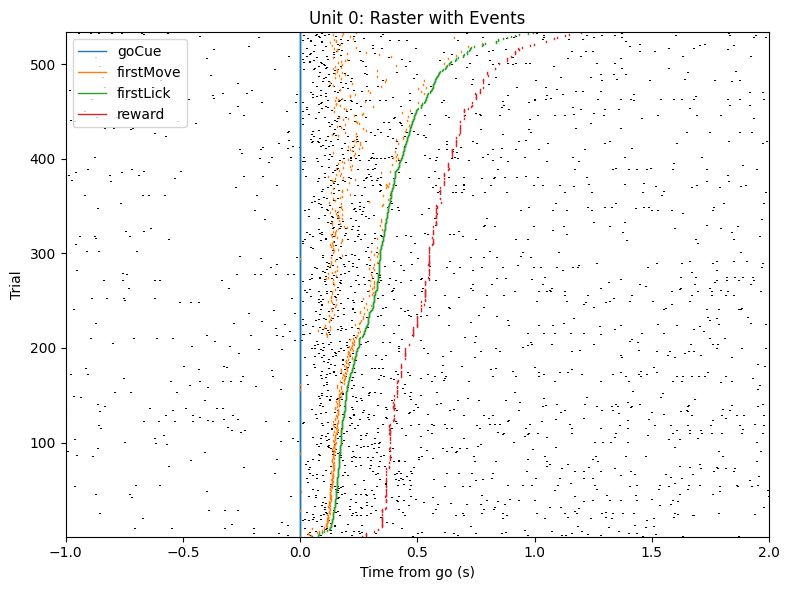

In [19]:
### example script demonstrating rasterplotter class

# 1) Prepare events df
E = build_event_df(events_dict=events_dict)

# 2) Choose trials (e.g., those with all events)
mask = E[['goCue','firstLick','firstMove']].notna().all(axis=1)
Ev = E.loc[mask]

# e.g. sort by firstLick - goCue
Ev = Ev.assign(Latency = Ev['firstLick'] - Ev['goCue'])
Ev = Ev.sort_values('Latency')
ordered_trials = Ev.index.tolist()

# 3) Create RasterPlotter for unit 0, aligned to goCue
spikes = ephys_data.iloc[0]['spike_times_in_session']
rp = RasterPlotter(
    spikes,
    ordered_trials,
    E['goCue'],
    pre=1,
    post=2,
    bin_size=0.001
)

# 4) Define overlay events, times, and styles
# Subtract goCue timing to get relative times for plotting
Rel = Ev[['goCue','firstLick','firstMove','reward']].subtract(Ev['goCue'], axis=0)
events = {}
colors = {'goCue':'C0','firstMove':'C1','firstLick':'C2','reward':'C3'}
for name in ['goCue','firstMove','firstLick','reward']:
    times = {i: Rel.loc[tr, name] for i, tr in enumerate(ordered_trials) if pd.notna(Rel.loc[tr,name])}
    events[name] = {'times': times, 'style': {'color': colors[name], 'linestyle':'-', 'linewidth':1}}

# 5) Plot
fig, ax = plt.subplots(figsize=(8,6))
rp.plot_with_events(events, ax=ax, spike_color='black')
ax.set_title('Unit 0: Raster with Events')
ax.set_xlabel('Time from go (s)')
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [20]:
def make_rp_and_events(
    spikes,
    trials: list,
    event_dicts: dict,
    align_by: str,
    sort_by: str,
    events_to_plot: Sequence[str] = None,
    pre: float = 1.0,
    post: float = 2.0,
    bin_size: float = 0.001,
):
    """
    spikes           : 1D array of spike times
    trials           : list of trial IDs (Ev.index)
    event_dicts      : {event_name -> {trial_id -> absolute_time}}
    align_by         : which event to align each trial on
    sort_by          : which event to sort trials by (latency from align_by)
    events_to_plot   : subset of event_names to overlay (defaults to all but align_by)
    pre, post, bin_size : raster params
    """
    # 1) sort trials
    ordered = sort_trials_by_latency(
        trials=trials,
        event_times=event_dicts,    # can look up both sort_by & align_by
        event1=sort_by,
        event2=align_by,
    )

    # 2) make raster aligned to align_by
    align_times = event_dicts[align_by]
    rp = RasterPlotter(spikes, ordered, align_times,
                       pre=pre, post=post, bin_size=bin_size)

    # 3) pick events
    if events_to_plot is None:
        events_to_plot = [e for e in event_dicts if e != align_by]

    # 4) build relative‐time dicts
    events = {}
    for ix, name in enumerate(events_to_plot):
        times_rel = {}
        for i, tr in enumerate(ordered):
            t_abs = event_dicts[name].get(tr)
            t0    = align_times.get(tr)
            if t_abs is not None and t0 is not None:
                times_rel[i] = t_abs - t0
        events[name] = {
            'times': times_rel,
            'style': {'color': f"C{ix}", 'linestyle':'--', 'linewidth':2}
        }

    return rp, events


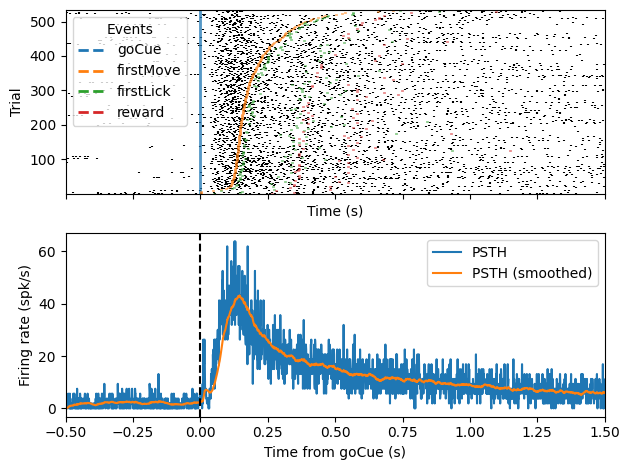

In [26]:
# once per script
E  = build_event_df(events_dict)
Ev = E.dropna(subset=['goCue','firstLick','firstMove'])
event_dicts = {n: Ev[n].to_dict() for n in Ev.columns}
trials = list(Ev.index)

# per unit
spikes = ephys_data.iloc[14]['spike_times_in_session']
rp, events = make_rp_and_events(
    spikes,
    trials,
    event_dicts,
    align_by='goCue',
    sort_by='firstMove',
    events_to_plot=['goCue','firstMove','firstLick','reward'],
    pre=0.5,
    post=1.5,
    bin_size=0.001
)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
rp.plot_raster(ax1)
rp.add_events(ax1, events)
ax1.legend(loc='upper left', title='Events')
psth, _  = compute_psth(rp.raster, bin_size=rp.bin_size)
psth_sm  = smooth_vector(psth, bin_size=rp.bin_size, sigma=0.025)
plot_psth(rp.bins, psth, psth_sm, ax=ax2)
ax2.set_xlabel(f"Time from goCue (s)")
plt.tight_layout()
plt.show()


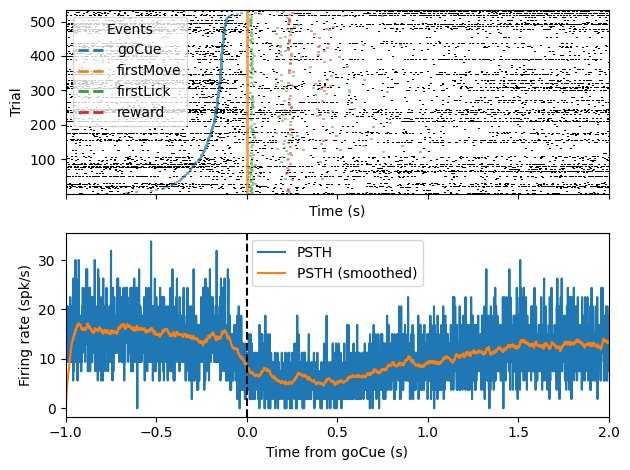

In [31]:

unit_n = 2
align_by = 'firstMove'
sort_by = 'goCue'

# per unit
spikes = ephys_data.iloc[unit_n]['spike_times_in_session']
rp, events = make_rp_and_events(
    spikes,
    trials,
    event_dicts,
    align_by=align_by,
    sort_by=sort_by,
    events_to_plot=['goCue','firstMove','firstLick','reward'],
    pre=1,
    post=2,
    bin_size=0.001
)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
rp.plot_raster(ax1)
rp.add_events(ax1, events)
ax1.legend(loc='upper left', title='Events')
psth, _  = compute_psth(rp.raster, bin_size=rp.bin_size)
psth_sm  = smooth_vector(psth, bin_size=rp.bin_size, sigma=0.025)
plot_psth(rp.bins, psth, psth_sm, ax=ax2)
ax2.set_xlabel(f"Time from goCue (s)")
plt.tight_layout()
plt.show()

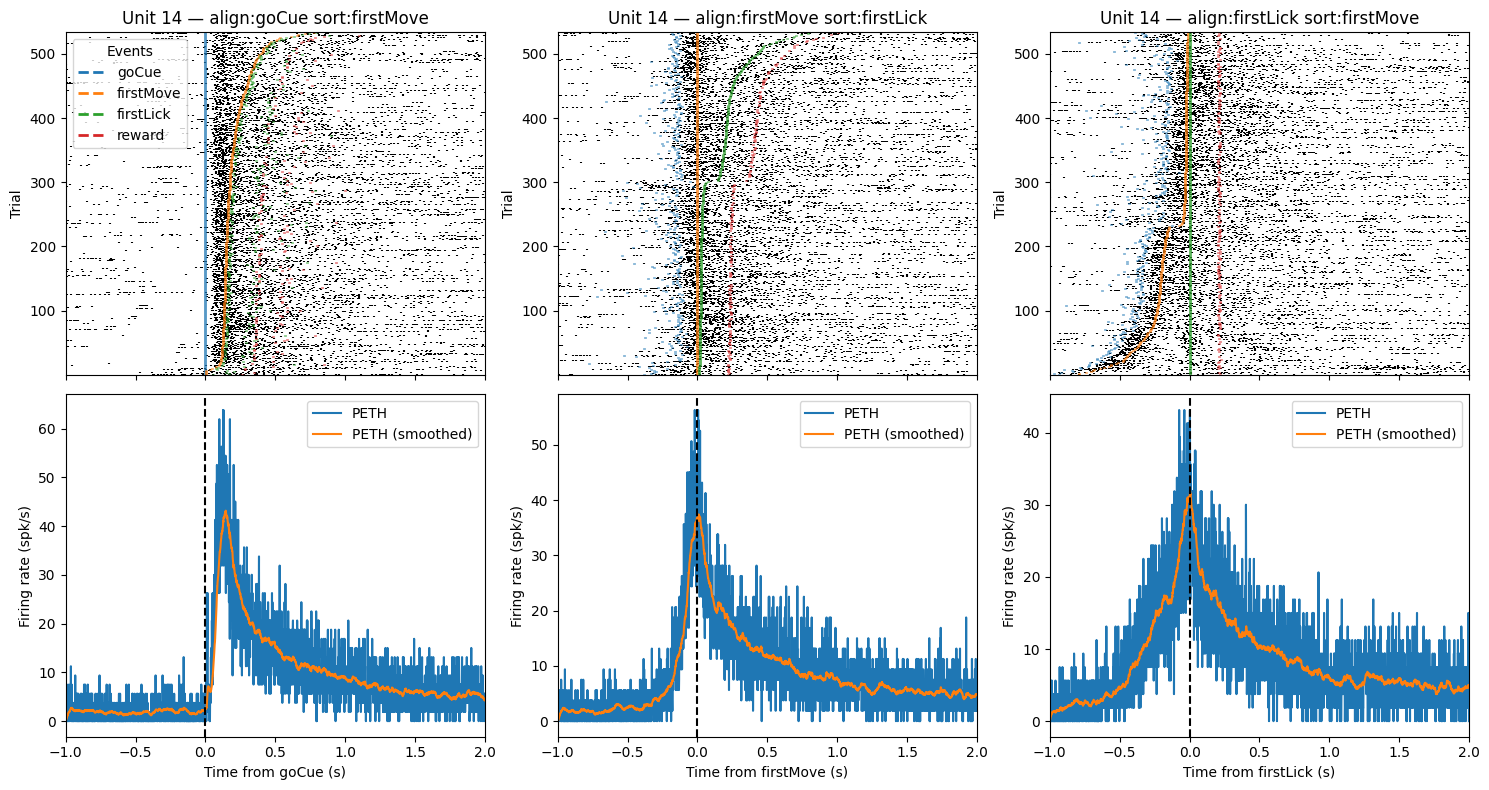

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# ————————————————————————————————————————————————
# 1) Build wide events DataFrame & filter
E  = build_event_df(events_dict)
Ev = E.dropna(subset=['goCue','firstLick','firstMove']).copy()

# ————————————————————————————————————————————————
# 2) Precompute once: trial list + event → {trial:time} mappings
trials = list(Ev.index)
event_dicts = {name: Ev[name].to_dict() for name in Ev.columns}

# ————————————————————————————————————————————————
# 3) Define the combos you want to plot
combos = [
    ('goCue',     'firstMove'),
    ('firstMove', 'firstLick'),
    ('firstLick', 'firstMove'),
]

# ————————————————————————————————————————————————
# 4) Helper to make the 2×3 figure for a single unit
def plot_unit_panels(spikes, unit_n,
                     trials,
                     event_dicts,
                     combos,
                     events_to_plot=None,
                     pre=1.0,
                     post=2.0,
                     bin_size=0.001,
                     sigma=0.025):
    """
    spikes         : 1D array of spike times
    trials         : list of trial IDs
    event_dicts    : {event_name -> {trial_id -> event_time}}
    combos         : list of (align_by, sort_by) pairs
    events_to_plot : list of event_names to overlay (defaults to all but align_by)
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex='col')

    for col, (align_by, sort_by) in enumerate(combos):
        # build the RasterPlotter + event overlays
        rp, events = make_rp_and_events(
            spikes,
            trials,
            event_dicts,
            align_by=align_by,
            sort_by=sort_by,
            events_to_plot=events_to_plot,  # or None to use all but align_by
            pre=pre,
            post=post,
            bin_size=bin_size
        )

        # top row: raster + event lines
        ax_r = axes[0, col]
        rp.plot_raster(ax=ax_r, spike_color='black')
        rp.add_events(ax_r, events)
        ax_r.set_title(f'Unit {unit_n} — align:{align_by} sort:{sort_by}')
        if col == 0:
            ax_r.set_ylabel('Trial')
            ax_r.legend(loc='upper left', title='Events')
        ax_r.set_xlabel(None)

        # bottom row: PSTH
        ax_p = axes[1, col]
        psth, _    = compute_psth(rp.raster, bin_size=rp.bin_size)
        psth_sm    = smooth_vector(psth, bin_size=rp.bin_size, sigma=sigma)
        plot_psth(rp.bins, psth, psth_sm, ax=ax_p, label='PETH')
        if col == 0:
            ax_p.set_ylabel('Firing rate (spk/s)')
        ax_p.set_xlabel(f'Time from {align_by} (s)')

    plt.tight_layout()
    return fig

# ————————————————————————————————————————————————
# 5) Loop over units and show/save
unit_list = [14]

for unit_n in unit_list:
    spikes = ephys_data.iloc[unit_n]['spike_times_in_session']
    fig = plot_unit_panels(
        spikes,
        unit_n,
        trials,
        event_dicts,
        combos,
        events_to_plot=['goCue', 'firstMove', 'firstLick', 'reward'],  # or None
        pre=1.0,
        post=2.0,
        bin_size=0.001,
        sigma=0.025
    )
    plt.show()
    # optionally: fig.savefig(f"unit_{unit_n}_panels.pdf")


In [33]:
import json
import pandas as pd


#mask units

# — your existing mapping from JSON keys to DataFrame columns —
col_map = {
    'isi_violations': 'isi_violations_ratio',
    # 'p_max':          'p_max',
    # 'lat_max_p':      'lat_max_p',
    # 'eu':             'euc_max_p',
    # 'corr':           'corr_max_p',
    'qc_pass':        'default_qc',
    'peak':           'peak',
    'in_df':          'real_unit',
}

# load filters
with open('/root/capsule/scratch/beh_all.json','r') as f:
    filters = json.load(f)

# initialize cumulative mask (start with all True)
mask = pd.Series(True, index=ephys_data.index)

for key, spec in filters.items():
    col = col_map.get(key)
    if col not in ephys_data.columns:
        print(f"\n no column mapped for filter '{key}' → skipping")
        continue

    print(f"\nFilter '{key}' → column '{col}':")
    series = ephys_data[col]

    # build this-filter mask
    this_mask = pd.Series(True, index=series.index)

    # bounds check
    if 'bounds' in spec:
        lo, hi = spec['bounds']
        inside_bounds = series.between(lo, hi)
        outside = (~inside_bounds & mask).sum()
        total   = mask.sum()
        this_mask &= inside_bounds
        print(f"  JSON bounds: [{lo}, {hi}]")
        print(f"  {outside}/{total} rows in the CURRENT set ({outside/total:.1%}) would be filtered by this bound")

    # membership check
    if 'items' in spec:
        allowed = set(spec['items'])
        in_items = series.isin(allowed)
        outside = (~in_items & mask).sum()
        total   = mask.sum()
        this_mask &= in_items
        print(f"  JSON items: {allowed}")
        print(f"  {outside}/{total} rows in the CURRENT set ({outside/total:.1%}) would be filtered by this membership")

    # update the cumulative mask
    mask &= this_mask

# final summary
total_units    = len(mask)
kept_units     = mask.sum()
filtered_units = total_units - kept_units
print(f"\n **FINAL**: out of {total_units} neurons, {filtered_units} ({filtered_units/total_units:.1%}) are filtered out, leaving {kept_units} units.")



Filter 'isi_violations' → column 'isi_violations_ratio':
  JSON bounds: [0.0, 0.1]
  136/281 rows in the CURRENT set (48.4%) would be filtered by this bound

 no column mapped for filter 'p_max' → skipping

 no column mapped for filter 'lat_max_p' → skipping

 no column mapped for filter 'eu' → skipping

 no column mapped for filter 'corr' → skipping

Filter 'qc_pass' → column 'default_qc':
  JSON items: {True}
  36/145 rows in the CURRENT set (24.8%) would be filtered by this membership

Filter 'peak' → column 'peak':
  JSON bounds: [-1000, 0]
  30/109 rows in the CURRENT set (27.5%) would be filtered by this bound

 no column mapped for filter 'trial_count' → skipping

Filter 'in_df' → column 'real_unit':
  JSON items: {True}
  0/79 rows in the CURRENT set (0.0%) would be filtered by this membership

 **FINAL**: out of 281 neurons, 202 (71.9%) are filtered out, leaving 79 units.


In [34]:
# passing_units = ephys_data[mask]
# unit_list = list(range(passing_units.shape[0]))

# with PdfPages('/root/capsule/scratch/figures/masked_units_raster_psth_alignments_recheck.pdf') as pdf:
#     for unit_n in unit_list:
#         spikes = ephys_data.iloc[unit_n]['spike_times_in_session']
#         fig = plot_unit_panels(
#             spikes,
#             unit_n,
#             trials,
#             event_dicts,
#             combos,
#             events_to_plot=['goCue', 'firstMove', 'firstLick', 'reward'],  # or None
#             pre=1.0,
#             post=2.0,
#             bin_size=0.001,
#             sigma=0.025
#         )
#         pdf.savefig(fig)
#         plt.close(fig)

# # print("✅ Saved all_units_raster_psth.pdf")

In [124]:
def plot_population_psth_heatmap(
    ephys_data,
    event_times_by_trial,  # 👈 replaces events_dict + align_event
    unit_selector_list=None,
    pre=0.5,
    post=1.5,
    bin_size=0.001,
    smooth_sigma=0.025,
    trial_subset=None,
    fr_range=None,
    cmap='viridis',
    ax=None
):
    """
    Create a population PSTH heatmap using precomputed event times.

    Parameters
    ----------
    ephys_data : DataFrame
        Must contain 'spike_times_in_session'.
    event_times_by_trial : dict
        Mapping trial numbers to alignment times (in session time).
    unit_selector_list : list
        List of unit indices or selector functions. If None, include all.
    pre, post, bin_size : float
        Time window and resolution.
    smooth_sigma : float
        Smoothing Gaussian sigma in seconds.
    trial_subset : list
        Optional subset of trials to include.
    fr_range : tuple
        (vmin, vmax) for color scale.
    cmap : str
        Matplotlib colormap name.
    ax : matplotlib Axes or None
        Axes to plot into.
    """
    if unit_selector_list is None:
        unit_selector_list = list(range(len(ephys_data)))

    valid_trials = list(event_times_by_trial.keys())
    if trial_subset is not None:
        valid_trials = list(set(valid_trials) & set(trial_subset))

    # Define bins
    n_bins = int(np.round((pre + post) / bin_size))
    bins = np.linspace(-pre, post, n_bins, endpoint=False) + bin_size / 2

    # Compute PSTHs
    psth_matrix = []
    for sel in unit_selector_list:
        unit_idx = ephys_data.index.get_loc(sel(ephys_data)) if callable(sel) else sel
        spikes = ephys_data.iloc[unit_idx]['spike_times_in_session']

        raster, _, _ = compute_raster_matrix(
            spikes,
            valid_trials,
            event_times_by_trial,
            pre=pre,
            post=post,
            bin_size=bin_size
        )
        psth, _ = compute_psth(raster, bin_size=bin_size)
        psth_smooth = smooth_vector(psth, bin_size=bin_size, sigma=smooth_sigma)
        psth_matrix.append(psth_smooth)

    psth_matrix = np.array(psth_matrix)

    # Dynamic figure sizing
    # fig_height = max(2, len(psth_matrix) * 0.15)
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    else:
        fig = ax.figure

    # Plot heatmap
    im = ax.imshow(
        psth_matrix,
        interpolation='none',
        aspect='auto',
        extent=[-pre, post, 0, len(psth_matrix)],
        origin='lower',
        cmap=cmap,
        vmin=fr_range[0] if fr_range else None,
        vmax=fr_range[1] if fr_range else None
    )

    ax.axvline(0, color='k', linestyle='--')
    ax.set_ylabel('Unit #')
    ax.set_xlabel('Time from event (s)')
    ax.set_title('Population PSTH')
    plt.colorbar(im, ax=ax, label='Firing Rate (spk/s)')
    plt.tight_layout()

    return fig, ax, psth_matrix


In [81]:
unit_list = list(range(ephys_data.shape[0]))  # or custom selectors


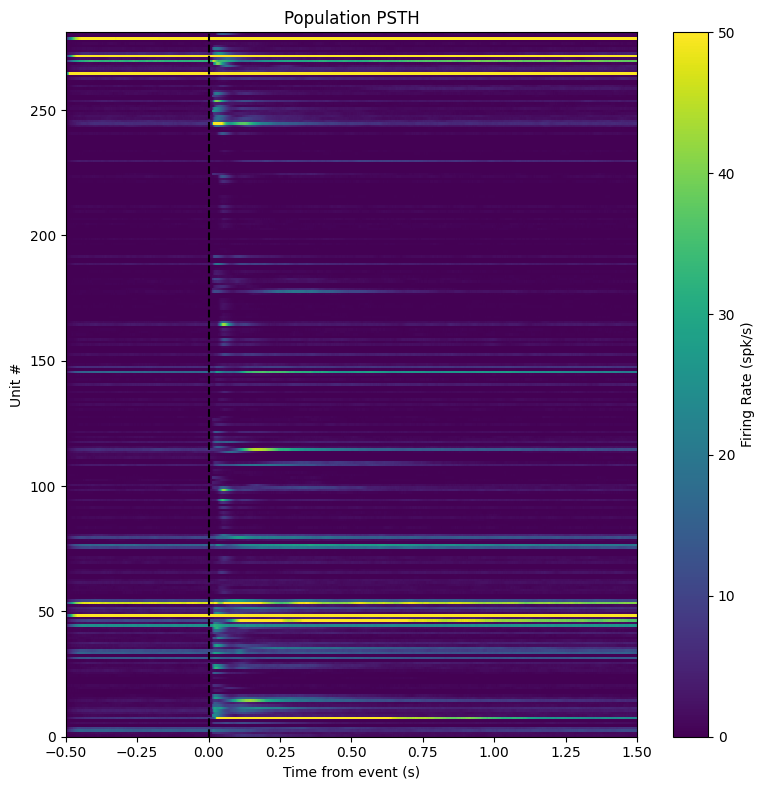

In [125]:
unit_list = list(range(ephys_data.shape[0]))  # or custom selectors
# unit_list = list(range(50))  # or custom selectors


# # Precompute event times once
# go_times = generate_event_times(*events['goCue'])
# first_lick_times = generate_event_times(*events['firstLick'], cue_times=go_times)
# first_move_times = generate_event_times(*events['firstMove'], cue_times=go_times)

event_times_by_trial = go_times

fig, ax, psth_matrix_go = plot_population_psth_heatmap(
    ephys_data,
    event_times_by_trial,
    unit_selector_list=unit_list,
    pre=0.5,
    post=1.5,
    fr_range=(0, 50)  # optional: control color scale
)
plt.show()


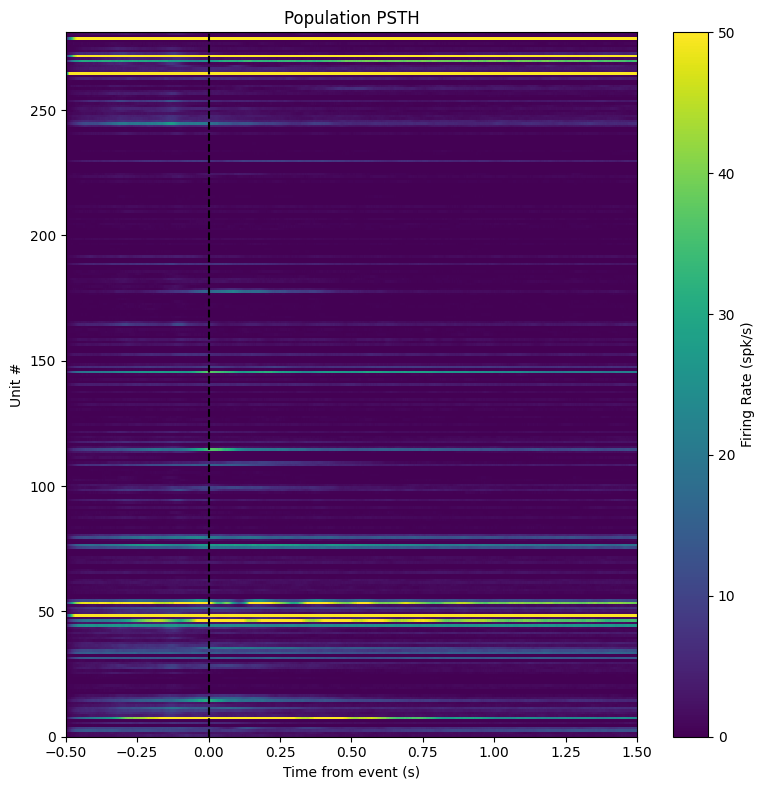

In [126]:
unit_list = list(range(ephys_data.shape[0]))  # or custom selectors
# unit_list = list(range(50))  # or custom selectors


# # Precompute event times once
# go_times = generate_event_times(*events['goCue'])
# first_lick_times = generate_event_times(*events['firstLick'], cue_times=go_times)
# first_move_times = generate_event_times(*events['firstMove'], cue_times=go_times)

event_times_by_trial = first_lick_times

fig, ax, psth_matrix_lick = plot_population_psth_heatmap(
    ephys_data,
    event_times_by_trial,
    unit_selector_list=unit_list,
    pre=0.5,
    post=1.5,
    fr_range=(0, 50)  # optional: control color scale
)
plt.show()


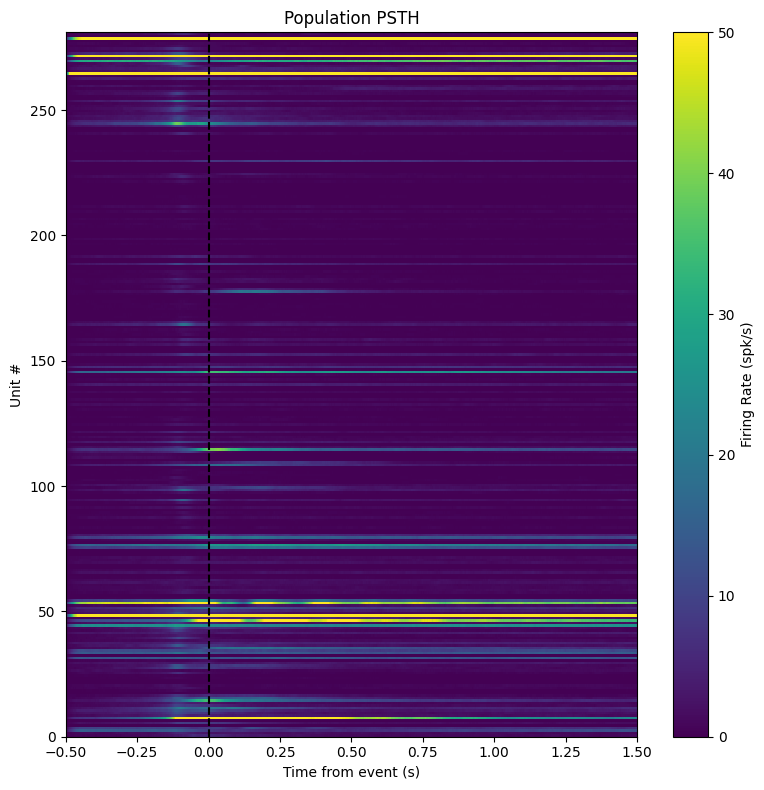

In [127]:
unit_list = list(range(ephys_data.shape[0]))  # or custom selectors
# unit_list = list(range(50))  # or custom selectors


# # Precompute event times once
# go_times = generate_event_times(*events['goCue'])
# first_lick_times = generate_event_times(*events['firstLick'], cue_times=go_times)
# first_move_times = generate_event_times(*events['firstMove'], cue_times=go_times)

event_times_by_trial = first_move_times

fig, ax, psth_matrix_move = plot_population_psth_heatmap(
    ephys_data,
    event_times_by_trial,
    unit_selector_list=unit_list,
    pre=0.5,
    post=1.5,
    fr_range=(0, 50)  # optional: control color scale
)
plt.show()


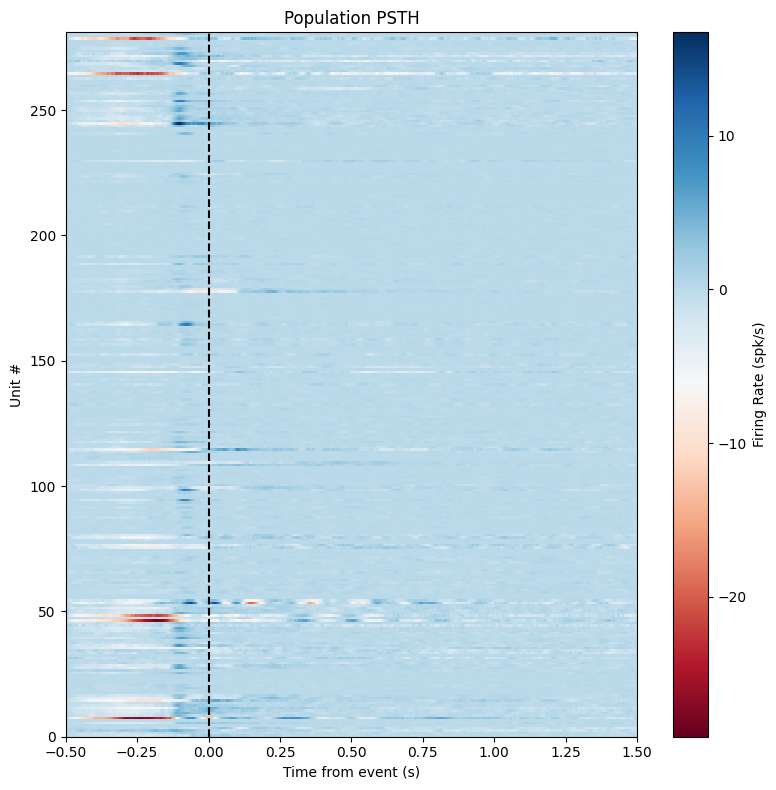

In [129]:
subtract_psth = psth_matrix_move - psth_matrix_lick
fig, ax = plt.subplots(figsize=(8, 8))

# Plot heatmap
im = ax.imshow(
    subtract_psth,
    interpolation='none',
    aspect='auto',
    extent=[-0.5, 1.5, 0, len(subtract_psth)],
    origin='lower',
    cmap='RdBu'
)

ax.axvline(0, color='k', linestyle='--')
ax.set_ylabel('Unit #')
ax.set_xlabel('Time from event (s)')
ax.set_title('delta PSTH (move - lick)')
plt.colorbar(im, ax=ax, label='delta Firing Rate (spk/s)')
plt.tight_layout()

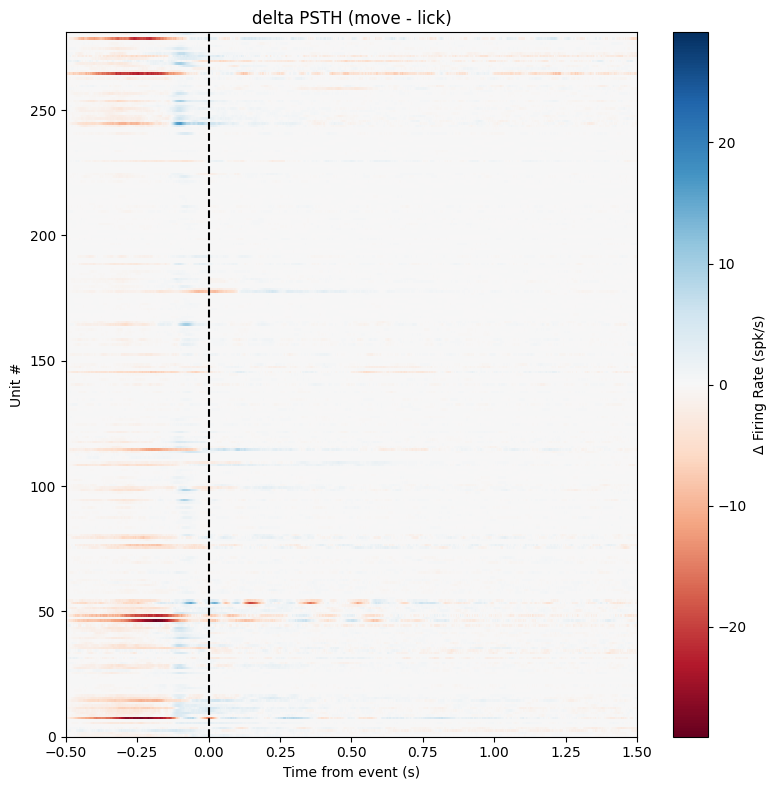

In [132]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import TwoSlopeNorm

# Example data (you can skip this if already defined)
subtract_psth = psth_matrix_move - psth_matrix_lick

# Compute symmetric range around 0
vmax = np.max(np.abs(subtract_psth))
vmin = -vmax

# Create a normalization with midpoint at 0
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(
    subtract_psth,
    interpolation='none',
    aspect='auto',
    extent=[-0.5, 1.5, 0, len(subtract_psth)],
    origin='lower',
    cmap='RdBu',
    norm=norm
)

ax.axvline(0, color='k', linestyle='--')
ax.set_ylabel('Unit #')
ax.set_xlabel('Time from event (s)')
ax.set_title('delta PSTH (move - lick)')
plt.colorbar(im, ax=ax, label='Δ Firing Rate (spk/s)')
plt.tight_layout()
plt.show()
